<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/2D_Pore_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

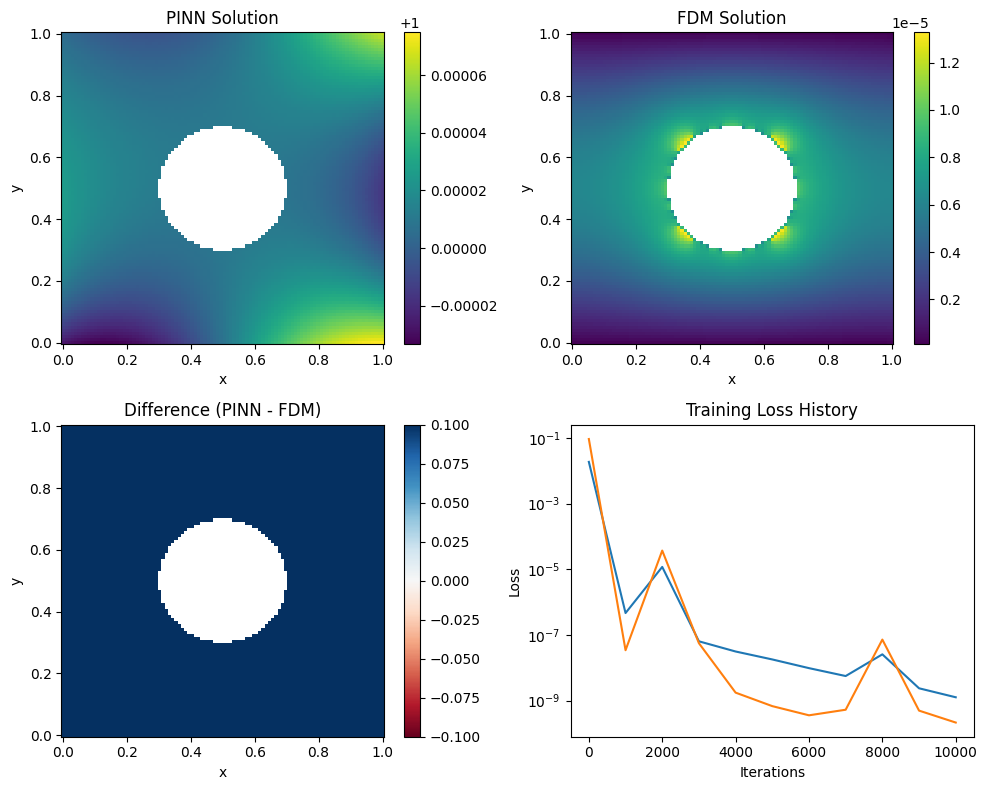

In [11]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]
points = np.hstack((X_flat, Y_flat))

Z_pinn = model.predict(points)[:, 0].reshape(X.shape)

mask = (X - 0.5)**2 + (Y - 0.5)**2 <= 0.2**2
Z_pinn[mask] = np.nan

plt.figure(figsize=(10, 8))
plt.subplot(221)
im = plt.pcolormesh(X, Y, Z_pinn, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('y')

def fdm_solution(nx, ny, D, k, alpha):
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)

    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx*ny)
    off_diag_x = 1/dx**2 * np.ones(nx*ny-1)
    off_diag_y = 1/dy**2 * np.ones(nx*ny-ny)

    A = diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
              [0, 1, -1, ny, -ny], format='csr')

    b = np.zeros(nx*ny)
    for i in range(nx):
        for j in range(ny):
            idx = i*ny + j
            x, y = i*dx, j*dy
            if (x-0.5)**2 + (y-0.5)**2 <= 0.2**2:
                A[idx, :] = 0
                A[idx, idx] = 1
                b[idx] = 0
            elif (x-0.5)**2 + (y-0.5)**2 <= 0.21**2:  # Boundary approx
                A[idx, idx] -= k/D
                b[idx] = -k*alpha/D

    u = spsolve(A, b)
    return u.reshape((nx, ny))

Z_fdm = fdm_solution(100, 100, D, k, alpha)
Z_fdm[mask] = np.nan

plt.subplot(222)
im = plt.pcolormesh(X, Y, Z_fdm, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('FDM Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(223)
diff = Z_pinn - Z_fdm
im = plt.pcolormesh(X, Y, diff, shading='auto', cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(im)
plt.title('Difference (PINN - FDM)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(224)
plt.semilogy(losshistory.steps, losshistory.loss_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')

plt.tight_layout()
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.105642 s

'compile' took 1.329493 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [7.59e-02, 2.76e-02, 3.87e-02, 2.24e-02, 7.43e-01, 5.19e-02]    [6.99e-02, 1.57e-02, 3.87e-02, 2.24e-02, 7.43e-01, 5.19e-02]    []  
1000      [9.40e-04, 1.06e-04, 9.73e-04, 2.36e-06, 2.19e-03, 1.17e-03]    [6.11e-04, 7.86e-05, 9.73e-04, 2.36e-06, 2.19e-03, 1.17e-03]    []  
2000      [6.78e-04, 2.31e-04, 4.55e-04, 9.71e-07, 5.94e-04, 6.61e-04]    [4.89e-04, 1.49e-04, 4.55e-04, 9.71e-07, 5.94e-04, 6.61e-04]    []  
3000      [3.38e-04, 1.27e-04, 6.13e-05, 1.25e-06, 1.15e-04, 1.38e-04]    [2.22e-04, 7.81e-05, 6.13e-05, 1.25e-06, 1.15e-04, 1.38e-04]    []  
4000      [2.13e-04, 1.56e-04, 9.52e-05, 1.77e-06, 6.76e-05, 4.91e-05]    [1.70e-04, 4.27e-05, 9.52e-05, 1.77e-06, 6.76e-05, 4.91e-05]    []  
5000 

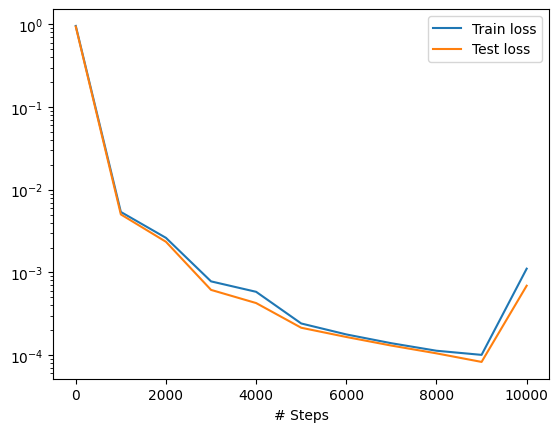

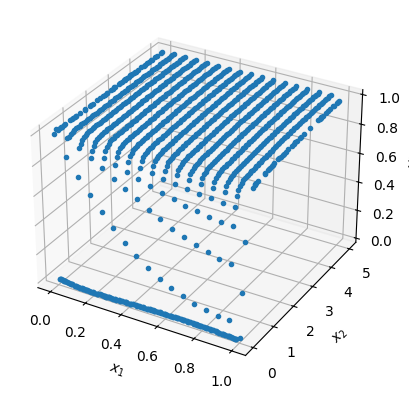

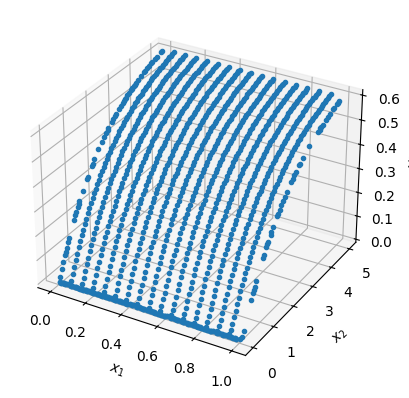

<ipython-input-52-3fb18fb37779>:106: RuntimeWarning: overflow encountered in scalar divide
  C_xx = (C_fdm[n, i+1] - 2 * C_fdm[n, i] + C_fdm[n, i-1]) / (dx**2)
<ipython-input-52-3fb18fb37779>:105: RuntimeWarning: overflow encountered in scalar divide
  C_x = (C_fdm[n, i+1] - C_fdm[n, i-1]) / (2 * dx)


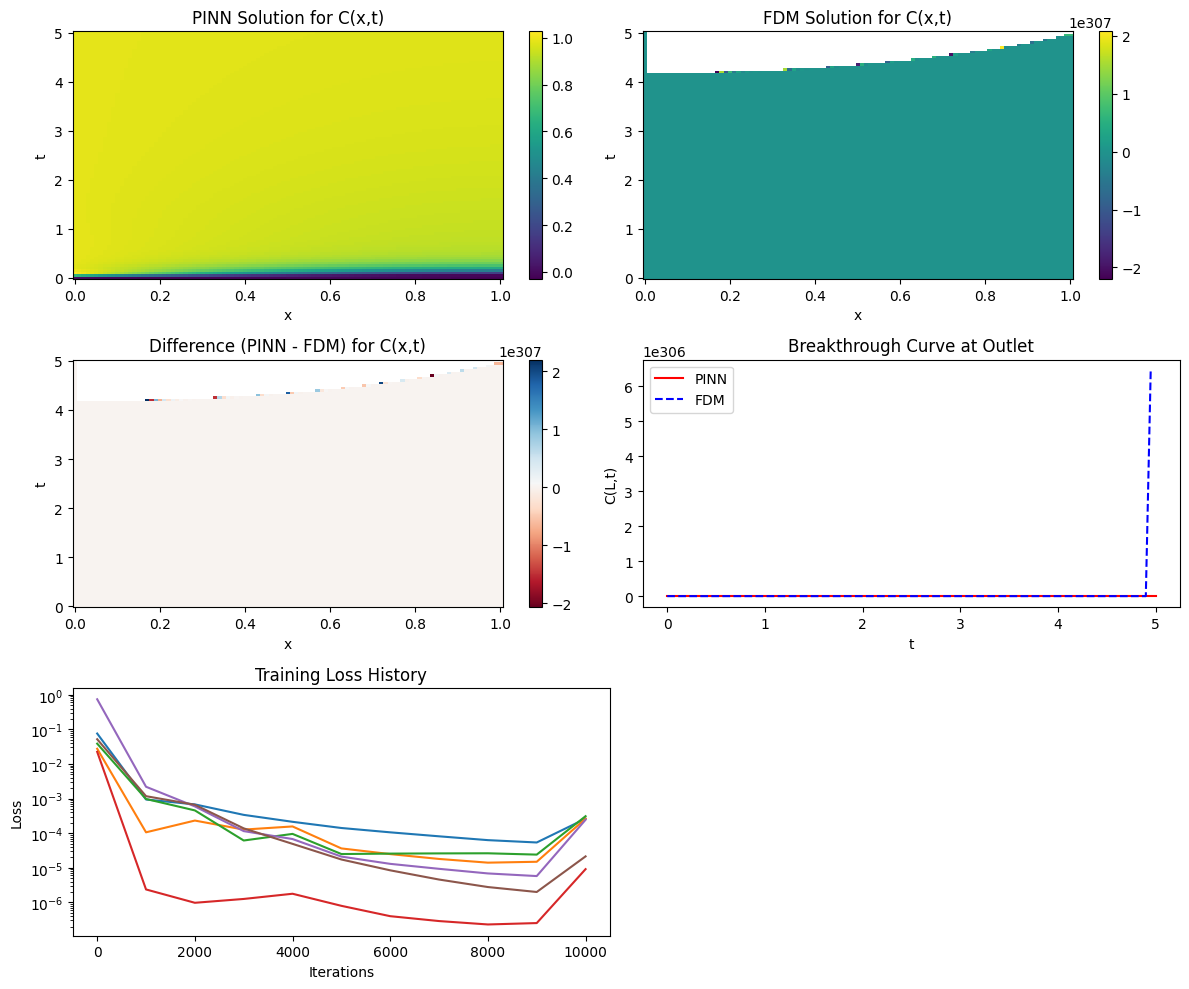

In [52]:
!pip install deepxde

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the fixed-bed reactor
L = 1.0              # reactor length
T_final = 5.0        # final time
epsilon = 0.4        # bed porosity
D = 1.0              # diffusivity
v = 1.0              # superficial velocity
k_a = 0.5            # adsorption rate constant
q_max = 1.0          # maximum adsorption capacity
b = 2.0              # Langmuir parameter
C_in = 1.0           # inlet concentration

# Define the space-time domain: x in [0,L] and t in [0,T_final]
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T_final)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# PDE system: u = [C, q]
def pde(x, u):
    C = u[:, 0:1]
    q = u[:, 1:2]
    C_t = dde.grad.jacobian(u, x, i=0, j=1)
    q_t = dde.grad.jacobian(u, x, i=1, j=1)
    C_x = dde.grad.jacobian(u, x, i=0, j=0)
    C_xx = dde.grad.hessian(u, x, i=0, j=0)
    # Langmuir isotherm equilibrium
    q_star = (q_max * b * C) / (1 + b * C)
    eq1 = epsilon * C_t + (1 - epsilon) * q_t + v * C_x - D * C_xx
    eq2 = q_t - k_a * (q_star - q)
    return [eq1, eq2]

# Initial conditions: at t=0, C = 0 and q = 0 for all x.
def initial_func_C(x):
    return 0.0

def initial_func_q(x):
    return 0.0

ic_C = dde.icbc.IC(geomtime, initial_func_C, lambda x, on_initial: on_initial and np.isclose(x[1], 0), component=0)
ic_q = dde.icbc.IC(geomtime, initial_func_q, lambda x, on_initial: on_initial and np.isclose(x[1], 0), component=1)

# Boundary condition at the inlet: Dirichlet for C at x = 0, C(0,t) = C_in.
bc_inlet = dde.icbc.DirichletBC(geomtime, lambda x: C_in,
                                lambda x, on_boundary: on_boundary and np.isclose(x[0], 0), component=0)

# Boundary condition at the outlet: Neumann for C at x = L, i.e. dC/dx = 0.
bc_outlet = dde.icbc.NeumannBC(
    geomtime,
    lambda x: 0.0,  # Explicitly set normal derivative to 0
    lambda x, on_boundary: on_boundary and np.isclose(x[0], L),
    component=0
)


bcs = [ic_C, ic_q, bc_inlet, bc_outlet]

# Create the PDE data object
data = dde.data.TimePDE(
    geomtime,
    pde,
    bcs,
    num_domain=2000,
    num_boundary=100,
    num_initial=100,
    num_test=1000,
)

# Define a feed-forward neural network with 2 inputs (x, t) and 2 outputs (C, q)
net = dde.nn.FNN([2] + [50] * 4 + [2], "tanh", "Glorot normal")

# Compile and train the model
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# ----- Finite Difference Method (FDM) solution for comparison -----
nx = 101
nt = 101
dx = L / (nx - 1)
dt = T_final / (nt - 1)

x_grid = np.linspace(0, L, nx)
t_grid = np.linspace(0, T_final, nt)
C_fdm = np.zeros((nt, nx))
q_fdm = np.zeros((nt, nx))

# Apply inlet condition for all time steps
C_fdm[:, 0] = C_in

for n in range(nt-1):
    # Update q at all spatial points (pointwise ODE)
    for i in range(nx):
        q_star = (q_max * b * C_fdm[n, i]) / (1 + b * C_fdm[n, i])
        q_fdm[n+1, i] = q_fdm[n, i] + dt * k_a * (q_star - q_fdm[n, i])
    # Impose outlet Neumann BC for C at current time level
    C_fdm[n, -1] = C_fdm[n, -2]
    # Update C for interior points using explicit Euler and central differences
    for i in range(1, nx-1):
        C_x = (C_fdm[n, i+1] - C_fdm[n, i-1]) / (2 * dx)
        C_xx = (C_fdm[n, i+1] - 2 * C_fdm[n, i] + C_fdm[n, i-1]) / (dx**2)
        source = (1 - epsilon) * k_a * ((q_max * b * C_fdm[n, i]) / (1 + b * C_fdm[n, i]) - q_fdm[n, i])
        C_fdm[n+1, i] = C_fdm[n, i] - dt/epsilon * (source + v * C_x - D * C_xx)
    # Reapply the inlet and outlet conditions at the new time level
    C_fdm[n+1, 0] = C_in
    C_fdm[n+1, -1] = C_fdm[n+1, -2]

# ----- Evaluate the PINN solution on the same grid -----
X, T_mesh = np.meshgrid(x_grid, t_grid)
XT = np.hstack((X.flatten()[:, None], T_mesh.flatten()[:, None]))
u_pinn = model.predict(XT)
C_pinn = u_pinn[:, 0].reshape(X.shape)
q_pinn = u_pinn[:, 1].reshape(X.shape)

# ----- Plotting -----
plt.figure(figsize=(12, 10))

# PINN solution for C(x,t)
plt.subplot(321)
plt.pcolormesh(X, T_mesh, C_pinn, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('PINN Solution for C(x,t)')
plt.xlabel('x')
plt.ylabel('t')

# FDM solution for C(x,t)
plt.subplot(322)
plt.pcolormesh(X, T_mesh, C_fdm, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('FDM Solution for C(x,t)')
plt.xlabel('x')
plt.ylabel('t')

# Difference between PINN and FDM for C(x,t)
plt.subplot(323)
plt.pcolormesh(X, T_mesh, C_pinn - C_fdm, shading='auto', cmap='RdBu')
plt.colorbar()
plt.title('Difference (PINN - FDM) for C(x,t)')
plt.xlabel('x')
plt.ylabel('t')

# Breakthrough curve: Outlet concentration C(L,t)
plt.subplot(324)
plt.plot(t_grid, C_pinn[:, -1], 'r-', label='PINN')
plt.plot(t_grid, C_fdm[:, -1], 'b--', label='FDM')
plt.xlabel('t')
plt.ylabel('C(L,t)')
plt.title('Breakthrough Curve at Outlet')
plt.legend()

# Training loss history
plt.subplot(325)
plt.semilogy(losshistory.steps, losshistory.loss_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')

plt.tight_layout()
plt.show()
